In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

# Fetch data
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=1095'
response = requests.get(url)
data = response.json()
hist_data = data['Data']['Data']
df = pd.DataFrame(hist_data)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df.drop(['conversionSymbol', 'conversionType'], axis=1, errors='ignore')


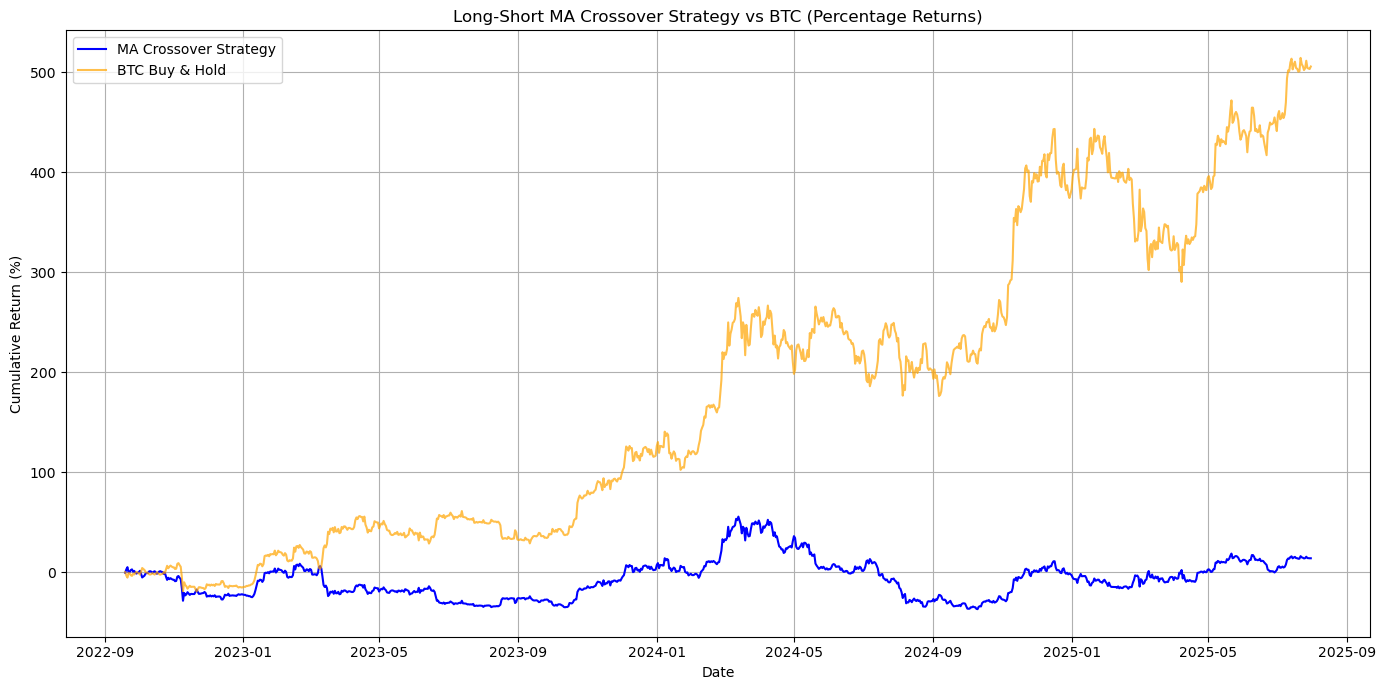

Strategy Total Return: 13.86%
BTC Buy & Hold Return: 505.59%
Maximum Drawdown: -59.50%
Annualized Return: 4.63%
Sharpe Ratio: 0.34
Win Rate: 49.86%


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
df['MA10'] = df['close'].rolling(window=10).mean()  
df['MA50'] = df['close'].rolling(window=50).mean()  

df = df.dropna(subset=['MA10', 'MA50'])


df['above'] = df['MA10'] > df['MA50']
df['above_prev'] = df['above'].shift(1).fillna(False)
df['cross_above'] = df['above'] & (~df['above_prev'])
df['cross_below'] = (~df['above']) & df['above_prev']


df['signal'] = 0
df.loc[df['cross_above'], 'signal'] = 1    
df.loc[df['cross_below'], 'signal'] = -1   

df['position'] = 0
position = -1  

for i in range(1, len(df)):
    sig = df['signal'].iloc[i-1]  
    if sig == 1:
        position = 1   
    elif sig == -1:
        position = -1  
    df['position'].iloc[i] = position


df['next_open'] = df['open'].shift(-1)
df['strategy_ret'] = np.where(
    df['position'] == 1,
    df['next_open'] / df['open'] - 1,  
    1 - (df['next_open'] / df['open']))  
df['strategy_ret'] = df['strategy_ret'].fillna(0)
df['strategy_cum_ret'] = (1 + df['strategy_ret']).cumprod()

df['btc_ret'] = df['close'].pct_change().fillna(0)
df['btc_cum_ret'] = (1 + df['btc_ret']).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['strategy_cum_ret'] * 100 - 100, label='MA Crossover Strategy', color='blue')
plt.plot(df.index, df['btc_cum_ret'] * 100 - 100, label='BTC Buy & Hold', color='orange', alpha=0.7)
plt.title('Long-Short MA Crossover Strategy vs BTC (Percentage Returns)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

final_strategy_ret = (df['strategy_cum_ret'].iloc[-1] - 1) * 100
final_btc_ret = (df['btc_cum_ret'].iloc[-1] - 1) * 100

print(f"Strategy Total Return: {final_strategy_ret:.2f}%")
print(f"BTC Buy & Hold Return: {final_btc_ret:.2f}%")

df['strategy_peak'] = df['strategy_cum_ret'].cummax()
df['strategy_drawdown'] = (df['strategy_cum_ret'] - df['strategy_peak']) / df['strategy_peak'] * 100
max_drawdown = df['strategy_drawdown'].min()
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

annualized_return = ((1 + final_strategy_ret/100) ** (365 / len(df)) - 1) * 100
sharpe_ratio = np.sqrt(365) * df['strategy_ret'].mean() / df['strategy_ret'].std()
win_rate = (df['strategy_ret'] > 0).sum() / len(df) * 100

print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Win Rate: {win_rate:.2f}%")


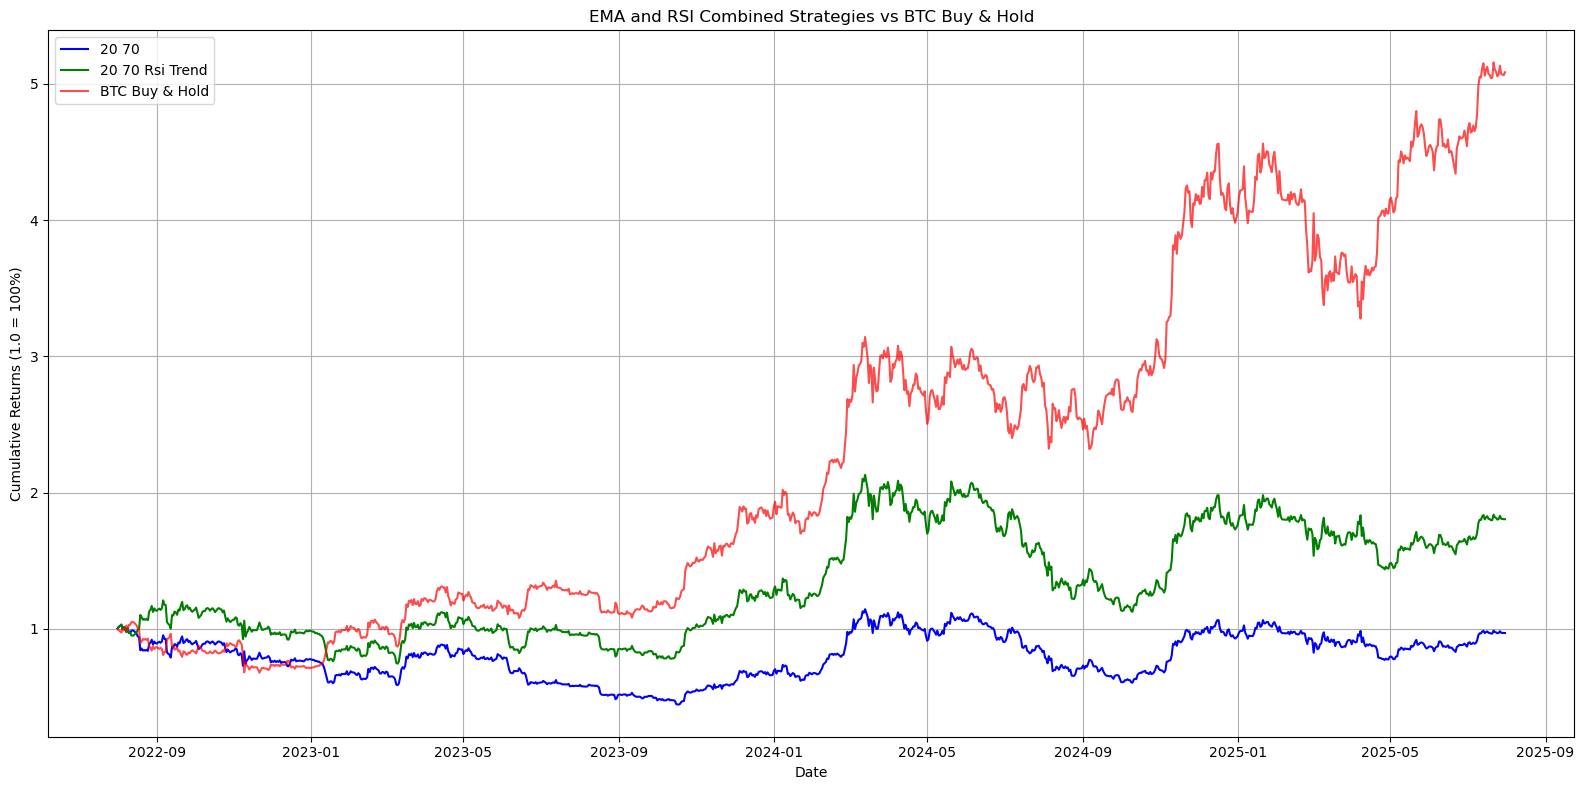


Strategy Returns and Maximum Drawdowns:
Strategy                  Return (%)      Max Drawdown (%)
------------------------------------------------------------
BTC Buy & Hold                408.56%         -35.54%
20 70                          -3.15%         -56.99%
20 70 Rsi Trend                80.44%         -47.19%


In [3]:
url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=1095'
response = requests.get(url)
data = response.json()
hist_data = data['Data']['Data']
df = pd.DataFrame(hist_data)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df.drop(['conversionSymbol', 'conversionType'], axis=1, errors='ignore')
df['EMA20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA70'] = df['close'].ewm(span=70, adjust=False).mean()
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI'] = calculate_rsi(df['close'], window=14)
df['next_open'] = df['open'].shift(-1)

#20/70 ema crossover strategy
df['above_20_70'] = df['EMA20'] > df['EMA70']
df['cross_above_20_70'] = df['above_20_70'] & (~df['above_20_70'].shift(1).fillna(False))
df['cross_below_20_70'] = (~df['above_20_70']) & df['above_20_70'].shift(1).fillna(True)
df['signal_20_70'] = 0
df.loc[df['cross_above_20_70'], 'signal_20_70'] = 1
df.loc[df['cross_below_20_70'], 'signal_20_70'] = -1
#20/70 EMA crossover + RSI
df['signal_20_70_rsi_trend'] = 0
df.loc[df['cross_above_20_70'] & (df['RSI'] > 50), 'signal_20_70_rsi_trend'] = 1
df.loc[df['cross_below_20_70'] & (df['RSI'] < 50), 'signal_20_70_rsi_trend'] = -1


strategies = ['signal_20_70','signal_20_70_rsi_trend']

for strat in strategies:
    pos_col = f'position_{strat}'
    ret_col = f'returns_{strat}'
    cum_col = f'cumulative_{strat}'

    df[pos_col] = 0
    position = -1  
    
    for i in range(1, len(df)):
        signal = df[strat].iloc[i-1]  
        if signal == 1:
            position = 1  
        elif signal == -1:
            position = -1  
        df[pos_col].iloc[i] = position
    
    # Strategy returns
    df[ret_col] = np.where(
        df[pos_col] == 1,
        df['next_open'] / df['open'] - 1,  # Long return
        1 - df['next_open'] / df['open']   # Short return
    )
    df[ret_col] = df[ret_col].fillna(0)  
    
    # Cumulative returns
    df[cum_col] = (1 + df[ret_col]).cumprod()

#Buy & hold returns
df['returns_buy_hold'] = df['close'].pct_change().fillna(0)
df['cumulative_buy_hold'] = (1 + df['returns_buy_hold']).cumprod()

plt.figure(figsize=(16, 8))

colors = ['blue', 'green']
for i, strat in enumerate(strategies):
    cum_col = f'cumulative_{strat}'
    strat_name = strat.replace('signal_', '').replace('_', ' ').title()
    plt.plot(df.index, df[cum_col], label=strat_name, color=colors[i])
plt.plot(df.index, df['cumulative_buy_hold'], label='BTC Buy & Hold', color='red', alpha=0.7)

plt.title('EMA and RSI Combined Strategies vs BTC Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns (1.0 = 100%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nStrategy Returns and Maximum Drawdowns:")
print("=" * 60)
print(f"{'Strategy':<25} {'Return (%)':<15} {'Max Drawdown (%)':<15}")
print("-" * 60)

final_buy_hold = df['cumulative_buy_hold'].iloc[-1]
return_buy_hold = (final_buy_hold - 1) * 100
df['peak_buy_hold'] = df['cumulative_buy_hold'].cummax()
df['drawdown_buy_hold'] = (df['cumulative_buy_hold'] - df['peak_buy_hold']) / df['peak_buy_hold'] * 100
max_drawdown_buy_hold = df['drawdown_buy_hold'].min()

print(f"{'BTC Buy & Hold':<25} {return_buy_hold:>10.2f}%     {max_drawdown_buy_hold:>10.2f}%")

for strat in strategies:
    cum_col = f'cumulative_{strat}'
    strat_name = strat.replace('signal_', '').replace('_', ' ').title()
    
    final_value = df[cum_col].iloc[-1]
    total_return = (final_value - 1) * 100
    
    peak_col = f'peak_{strat}'
    drawdown_col = f'drawdown_{strat}'
    df[peak_col] = df[cum_col].cummax()
    df[drawdown_col] = (df[cum_col] - df[peak_col]) / df[peak_col] * 100
    max_drawdown = df[drawdown_col].min()
    
    print(f"{strat_name:<25} {total_return:>10.2f}%     {max_drawdown:>10.2f}%")
